# RSNA2024 LSDC TRANSFORMING DICOM INTO PNG. 

## Code Purpose
The primary goal of this code is to convert DICOM images from the RSNA 2024 Lumbar Spine Degenerative Classification dataset into PNG format for further processing.

## Key steps:
- Reads CSV files containing image metadata.
- Iterates over study IDs and series descriptions.
- Loads DICOM images for each series.
- Preprocesses images (normalization, resizing).
- Saves preprocessed images as PNG files.



# Import Libraries

In [1]:
import pydicom #To read DICOM Images
import glob, os # File path manipulation
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm # Progress Bar
import re # For regular expressions (used in natural_keys custom function)

# Define helper functions

In [2]:
rd = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification'

In [3]:
def atoi(text):
  """Converts a string to an integer if possible.

  Args:
    text: The input string.

  Returns:
    The integer value of the string if it's a digit, otherwise the original string.
  """
  return int(text) if text.isdigit() else text

def natural_keys(text):
    """Sorts text containing numbers naturally.

    Args:
    text: The input text.

    Returns:
    A list of integers and strings, suitable for natural sorting.
    """
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

# Load CSV Data

In [4]:
dfc = pd.read_csv(f'{rd}/train_label_coordinates.csv')
dfc.head()

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602


In [5]:
df = pd.read_csv(f'{rd}/train_series_descriptions.csv')
df.head()

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1


# Analyze Series Descriptions

For each study_id, we can observe 3 to 6 series_ids.

In [6]:
print("Series Description Distribution:")
print(df['series_description'].value_counts())

Series Description Distribution:
series_description
Axial T2            2340
Sagittal T1         1980
Sagittal T2/STIR    1974
Name: count, dtype: int64


Example: Most studies with 4+ series_ids have 2+ Axial T2s


In [7]:
study_id = 4096820034
print(f"\nData for Study ID: {study_id}")
print(df[df['study_id'] == study_id])
print(dfc[dfc['study_id'] == study_id])



Data for Study ID: 4096820034
        study_id   series_id series_description
5997  4096820034   300517765           Axial T2
5998  4096820034  2097107888           Axial T2
5999  4096820034  2602265508   Sagittal T2/STIR
6000  4096820034  2679683906           Axial T2
6001  4096820034  3114813181           Axial T2
6002  4096820034  3236751045        Sagittal T1
         study_id   series_id  instance_number  \
46392  4096820034   300517765                5   
46393  4096820034   300517765               11   
46394  4096820034  2097107888               10   
46395  4096820034  2097107888               16   
46396  4096820034  2097107888               22   
46397  4096820034  2602265508                7   
46398  4096820034  2602265508                7   
46399  4096820034  2602265508                7   
46400  4096820034  2602265508                7   
46401  4096820034  2602265508                7   
46402  4096820034  2679683906               10   
46403  4096820034  2679683906    

Analyze Series Descriptions Relationship (Axial T2, Sagittal T2/STIR, Sagittal T1)
We can see that it corresponds as follows:

- Axial T2 => (Left|Right) Subarticular Stenosis (10 classes)
- Sagittal T2/STIR => Spinal Canal Stenosis (5 Classes)
- Sagittal T1 => (Left|Right) Neural Foraminal Narrowing (10 classes)

# Image Processing and Conversion
Export png from dcm
.dcm format files have various pixel values and image shapes. To use them in a deep learning framework, we will make the values ​​fall within a certain range and resize the shapes to 512px.

In [8]:
def imread_and_imwrite(src_path, dst_path):
    """Reads a DICOM image, normalizes and resizes it, then saves as a PNG.

    Args:
    src_path: Path to the input DICOM file.
    dst_path: Path to save the output PNG file.
    """
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    # Normalize pixel values (0-255)
    image = (image - image.min()) / (image.max() - image.min() +1e-6) * 255
    # Resize image to 512x512 using cubic interpolation for smoothness
    img = cv2.resize(image, (512, 512),interpolation=cv2.INTER_CUBIC)
    assert img.shape==(512,512)
    cv2.imwrite(dst_path, img)

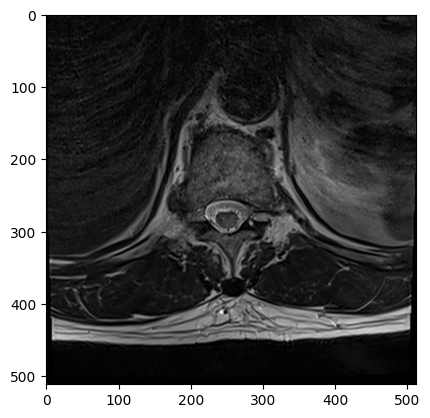

In [9]:
# Example usage (reading DICOM, converting to PNG, and displaying)
input_dicom_path = f"{rd}/train_images/100206310/1012284084/2.dcm"
output_png_path = "output_image.png"

imread_and_imwrite(input_dicom_path, output_png_path)

# Display the converted PNG image
img = cv2.imread(output_png_path)
plt.imshow(img, cmap='gray')
plt.show()

In [10]:
st_ids = df['study_id'].unique()
st_ids[:3], len(st_ids)

(array([4003253, 4646740, 7143189]), 1975)

In [11]:
desc = list(df['series_description'].unique())
desc

['Sagittal T2/STIR', 'Sagittal T1', 'Axial T2']

In [ ]:
for idx, si in enumerate(tqdm(st_ids, total=len(st_ids))):
    pdf = df[df['study_id']==si] # Filter data for current study
    for ds in desc:
        # Create folders for converted PNGs (study_id/series_description)
        ds_ = ds.replace('/', '_')
        pdf_ = pdf[pdf['series_description']==ds]
        os.makedirs(f'cvt_png/{si}/{ds_}', exist_ok=True)
        allimgs = [] # List to store all image paths for the current series
        for i, row in pdf_.iterrows():
            # Get DICOM image paths
            pimgs = glob.glob(f'{rd}/train_images/{row["study_id"]}/{row["series_id"]}/*.dcm')
            pimgs = sorted(pimgs, key=natural_keys)
            allimgs.extend(pimgs)
        
        # Check if there are any images for the series
        if len(allimgs)==0:
            print(si, ds, 'has no images')
            continue
            
        # Process series based on description
        if ds == 'Axial T2':
            # Save all DICOM images as PNGs
            for j, impath in enumerate(allimgs):
                dst = f'cvt_png/{si}/{ds}/{j:03d}.png'
                imread_and_imwrite(impath, dst)
                
        elif ds == 'Sagittal T2/STIR':
            # Select 10 equally spaced slices
            step = len(allimgs) / 10.0
            st = len(allimgs)/2.0 - 4.0*step
            end = len(allimgs)+0.0001
            for j, i in enumerate(np.arange(st, end, step)):
                dst = f'cvt_png/{si}/{ds_}/{j:03d}.png'
                ind2 = max(0, int((i-0.5001).round()))
                imread_and_imwrite(allimgs[ind2], dst)
                
            # Assert that 10 PNG files were created    
            assert len(glob.glob(f'cvt_png/{si}/{ds_}/*.png'))==10
                
        elif ds == 'Sagittal T1':
            # Select 10 equally spaced slices
            step = len(allimgs) / 10.0
            st = len(allimgs)/2.0 - 4.0*step
            end = len(allimgs)+0.0001
            for j, i in enumerate(np.arange(st, end, step)):
                dst = f'cvt_png/{si}/{ds}/{j:03d}.png'
                ind2 = max(0, int((i-0.5001).round()))
                imread_and_imwrite(allimgs[ind2], dst)
                
            # Assert that 10 PNG files were created    
            assert len(glob.glob(f'cvt_png/{si}/{ds}/*.png'))==10